<a href="https://colab.research.google.com/github/srnarasim/DataProcessingComparison/blob/main/scenario1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install polars duckdb pyarrow

# 🔬 Scenario 1: Interactive Data Science Analysis


---



In [ ]:
# Generate realistic sample data
import pandas as pd
import numpy as np
from datetime import datetime, timedelta


# Generate realistic e-commerce transaction data
def generate_sample_data(n_rows=10_000_000):
    """Generate realistic e-commerce transaction data for analysis"""
    np.random.seed(42)  # Reproducible results

    print(f"Generating {n_rows:,} realistic e-commerce transactions...")

    # Realistic customer and product distributions
    n_customers = 50_000
    n_products = 2_000

    customers = [f"CUST_{i:06d}" for i in range(1, n_customers + 1)]
    products = [f"PROD_{i:04d}" for i in range(1, n_products + 1)]
    categories = ['Electronics', 'Clothing', 'Books', 'Home', 'Sports', 'Beauty']

    # Create realistic transaction data
    data = {
        'customer_id': np.random.choice(customers, n_rows),
        'product_id': np.random.choice(products, n_rows),
        'product_category': np.random.choice(categories, n_rows),
        'order_total': np.random.lognormal(3, 1, n_rows).round(2),
        'order_date': [
            datetime(2023, 1, 1) + timedelta(days=np.random.randint(0, 730))
            for _ in range(n_rows)
        ],
        'order_id': [f"ORD_{i:08d}" for i in range(1, n_rows + 1)]
    }

    df = pd.DataFrame(data)
    print(f"✅ Generated dataset: {len(df):,} rows, ~{df.memory_usage(deep=True).sum() / 1024**2:.1f}MB")
    return df

In [ ]:
# Generate the dataset
transactions_df = generate_sample_data()

Generating 10,000,000 realistic e-commerce transactions...
✅ Generated dataset: 10,000,000 rows, ~2695.7MB


# 📊 Dataset Overview

In [ ]:
print(f"Shape: {transactions_df.shape}")
print(f"Date range: {transactions_df['order_date'].min()} to {transactions_df['order_date'].max()}")
print(f"Unique customers: {transactions_df['customer_id'].nunique():,}")
print(f"Unique products: {transactions_df['product_id'].nunique():,}")

Shape: (10000000, 6)
Date range: 2023-01-01 00:00:00 to 2024-12-30 00:00:00
Unique customers: 50,000
Unique products: 2,000


In [ ]:
# Save for use across different tools
transactions_df.to_csv('transactions.csv', index=False)
transactions_df.to_parquet('transactions.parquet', index=False)

# 🐼 PANDAS APPROACH - Customer Lifetime Value Analysis


---



In [ ]:
import time
def pandas_clv_analysis(df):
    """Customer Lifetime Value analysis using Pandas"""
    start_time = time.time()

    # Convert to datetime if not already
    df['order_date'] = pd.to_datetime(df['order_date'])

    # Complex aggregation with multiple metrics
    clv_data = (df.groupby('customer_id')
                .agg({
                    'order_total': ['sum', 'count', 'mean', 'std'],
                    'order_date': ['min', 'max'],
                    'product_category': 'nunique'
                })
                .round(2))

    # Flatten column names
    clv_data.columns = ['total_spent', 'order_count', 'avg_order', 'order_std',
                        'first_order', 'last_order', 'categories_purchased']

    # Calculate days active
    clv_data['days_active'] = (clv_data['last_order'] - clv_data['first_order']).dt.days

    # Calculate customer lifetime value score
    clv_data['clv_score'] = (
        clv_data['total_spent'] * 0.4 +
        clv_data['order_count'] * 10 * 0.3 +
        clv_data['categories_purchased'] * 20 * 0.3
    )

    # Filter active customers (more than 30 days, multiple orders)
    active_customers = clv_data[
        (clv_data['days_active'] > 30) &
        (clv_data['order_count'] > 1)
    ].copy()

    execution_time = time.time() - start_time

    return active_customers, execution_time

In [ ]:
# Execute Pandas analysis
pandas_result, pandas_time = pandas_clv_analysis(transactions_df)

print(f"⏱️  Execution time: {pandas_time:.2f} seconds")
print(f"📈 Active customers identified: {len(pandas_result):,}")
print(f"💾 Memory usage: ~{pandas_result.memory_usage(deep=True).sum() / 1024**2:.1f}MB")

print("\nTop 10 customers by CLV score:")
print(pandas_result.nlargest(10, 'clv_score')[['total_spent', 'order_count', 'clv_score']])

⏱️  Execution time: 4.51 seconds
📈 Active customers identified: 50,000
💾 Memory usage: ~7.7MB

Top 10 customers by CLV score:
             total_spent  order_count  clv_score
customer_id                                     
CUST_000558     10749.30          245   5070.720
CUST_028189     11200.19          171   5029.076
CUST_028789     10290.54          239   4869.216
CUST_021851     10267.69          234   4845.076
CUST_022942     10001.69          254   4798.676
CUST_041101     10086.87          236   4778.748
CUST_029530      9904.78          247   4738.912
CUST_026757     10139.51          212   4727.804
CUST_038170      9928.63          230   4697.452
CUST_020482      9873.33          235   4690.332


# ⚡ POLARS APPROACH - Customer Lifetime Value Analysis


---



In [ ]:
import time
import polars as pl

def polars_clv_analysis(df_path):
    """Customer Lifetime Value analysis using Polars"""
    start_time = time.time()

    # Read data with Polars
    df = pl.read_parquet(df_path)

    # Polars-style aggregation with method chaining
    clv_data = (df.group_by('customer_id')
                .agg([
                    pl.col('order_total').sum().alias('total_spent'),
                    pl.col('order_total').count().alias('order_count'),
                    pl.col('order_total').mean().alias('avg_order'),
                    pl.col('order_total').std().alias('order_std'),
                    pl.col('order_date').min().alias('first_order'),
                    pl.col('order_date').max().alias('last_order'),
                    pl.col('product_category').n_unique().alias('categories_purchased')
                ])
                .with_columns([
                    (pl.col('last_order') - pl.col('first_order')).dt.total_days().alias('days_active')
                ])
                .with_columns([
                    (pl.col('total_spent') * 0.4 +
                     pl.col('order_count') * 10 * 0.3 +
                     pl.col('categories_purchased') * 20 * 0.3).alias('clv_score')
                ])
                .filter(
                    (pl.col('days_active') > 30) &
                    (pl.col('order_count') > 1)
                ))

    execution_time = time.time() - start_time

    return clv_data, execution_time

In [ ]:
# Execute Polars analysis
polars_result, polars_time = polars_clv_analysis('transactions.parquet')

print(f"⏱️  Execution time: {polars_time:.2f} seconds")
print(f"📈 Active customers identified: {polars_result.height:,}")
print(f"⚡ Performance improvement: {pandas_time/polars_time:.1f}x faster than Pandas")

print("\nTop 10 customers by CLV score:")
print(polars_result.sort('clv_score', descending=True).head(10).select(['total_spent', 'order_count', 'clv_score']))

⏱️  Execution time: 3.68 seconds
📈 Active customers identified: 50,000
⚡ Performance improvement: 1.2x faster than Pandas

Top 10 customers by CLV score:
shape: (10, 3)
┌─────────────┬─────────────┬───────────┐
│ total_spent ┆ order_count ┆ clv_score │
│ ---         ┆ ---         ┆ ---       │
│ f64         ┆ u32         ┆ f64       │
╞═════════════╪═════════════╪═══════════╡
│ 10749.3     ┆ 245         ┆ 5070.72   │
│ 11200.19    ┆ 171         ┆ 5029.076  │
│ 10290.54    ┆ 239         ┆ 4869.216  │
│ 10267.69    ┆ 234         ┆ 4845.076  │
│ 10001.69    ┆ 254         ┆ 4798.676  │
│ 10086.87    ┆ 236         ┆ 4778.748  │
│ 9904.78     ┆ 247         ┆ 4738.912  │
│ 10139.51    ┆ 212         ┆ 4727.804  │
│ 9928.63     ┆ 230         ┆ 4697.452  │
│ 9873.33     ┆ 235         ┆ 4690.332  │
└─────────────┴─────────────┴───────────┘


# 🦆 DUCKDB APPROACH - Customer Lifetime Value Analysis


---



In [ ]:
import time
import duckdb

def duckdb_clv_analysis():
    """Customer Lifetime Value analysis using DuckDB SQL"""
    start_time = time.time()

    # Connect to DuckDB and register the parquet file
    conn = duckdb.connect()

    # DuckDB can directly query parquet files
    query = """
    SELECT
        customer_id,
        SUM(order_total) as total_spent,
        COUNT(*) as order_count,
        AVG(order_total) as avg_order,
        STDDEV(order_total) as order_std,
        MIN(order_date) as first_order,
        MAX(order_date) as last_order,
        COUNT(DISTINCT product_category) as categories_purchased,
        DATE_DIFF('day', MIN(order_date), MAX(order_date)) as days_active,
        (SUM(order_total) * 0.4 +
         COUNT(*) * 10 * 0.3 +
         COUNT(DISTINCT product_category) * 20 * 0.3) as clv_score
    FROM 'transactions.parquet'
    GROUP BY customer_id
    HAVING days_active > 30 AND order_count > 1
    ORDER BY clv_score DESC
    """

    result = conn.execute(query).fetchdf()
    execution_time = time.time() - start_time

    return result, execution_time

In [ ]:
# Execute DuckDB analysis
duckdb_result, duckdb_time = duckdb_clv_analysis()

print(f"⏱️  Execution time: {duckdb_time:.2f} seconds")
print(f"📈 Active customers identified: {len(duckdb_result):,}")
print(f"🚀 Performance improvement: {pandas_time/duckdb_time:.1f}x faster than Pandas")

print("\nTop 10 customers by CLV score:")
print(duckdb_result.head(10)[['total_spent', 'order_count', 'clv_score']])

print("\n" + "="*60)
print("📊 PERFORMANCE COMPARISON")
print("="*60)

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

⏱️  Execution time: 3.31 seconds
📈 Active customers identified: 50,000
🚀 Performance improvement: 1.4x faster than Pandas

Top 10 customers by CLV score:
   total_spent  order_count  clv_score
0     10749.30          245   5070.720
1     11200.19          171   5029.076
2     10290.54          239   4869.216
3     10267.69          234   4845.076
4     10001.69          254   4798.676
5     10086.87          236   4778.748
6      9904.78          247   4738.912
7     10139.51          212   4727.804
8      9928.63          230   4697.452
9      9873.33          235   4690.332

📊 PERFORMANCE COMPARISON


# 📊 PERFORMANCE COMPARISON


---



In [ ]:
# Create performance comparison
performance_data = {
    'Tool': ['Pandas', 'Polars', 'DuckDB'],
    'Execution Time (s)': [pandas_time, polars_time, duckdb_time],
    'Speed vs Pandas': [1.0, pandas_time/polars_time, pandas_time/duckdb_time],
    'Memory Efficiency': ['Baseline', 'Better', 'Good'],
    'Learning Curve': ['Easy', 'Moderate', 'Easy (SQL)']
}
performance_df = pd.DataFrame(performance_data)
print(performance_df.to_string(index=False))

  Tool  Execution Time (s)  Speed vs Pandas Memory Efficiency Learning Curve
Pandas            4.510406         1.000000          Baseline           Easy
Polars            3.677387         1.226525            Better       Moderate
DuckDB            3.310311         1.362533              Good     Easy (SQL)


In [ ]:
# Visualize performance comparison
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 8))

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

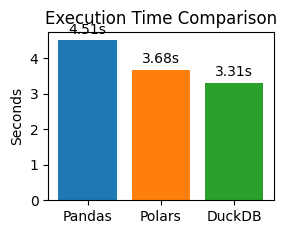

In [ ]:
# Execution time comparison
plt.subplot(2, 2, 1)
bars = plt.bar(performance_data['Tool'], performance_data['Execution Time (s)'],
               color=['#1f77b4', '#ff7f0e', '#2ca02c'])
plt.title('Execution Time Comparison')
plt.ylabel('Seconds')
for i, bar in enumerate(bars):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
             f'{performance_data["Execution Time (s)"][i]:.2f}s',
             ha='center', va='bottom')

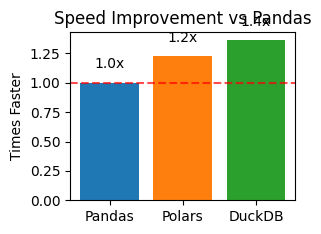

In [ ]:
# Speed improvement comparison
plt.subplot(2, 2, 2)
bars = plt.bar(performance_data['Tool'], performance_data['Speed vs Pandas'],
               color=['#1f77b4', '#ff7f0e', '#2ca02c'])
plt.title('Speed Improvement vs Pandas')
plt.ylabel('Times Faster')
plt.axhline(y=1, color='red', linestyle='--', alpha=0.7, label='Pandas Baseline')
for i, bar in enumerate(bars):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
             f'{performance_data["Speed vs Pandas"][i]:.1f}x',
             ha='center', va='bottom')

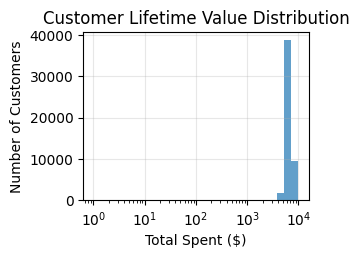

In [ ]:

# Customer distribution analysis
plt.subplot(2, 2, 3)
bins = np.logspace(0, 4, 30)
plt.hist(pandas_result['total_spent'], bins=bins, alpha=0.7, label='Customer Spend Distribution')
plt.xscale('log')
plt.xlabel('Total Spent ($)')
plt.ylabel('Number of Customers')
plt.title('Customer Lifetime Value Distribution')
plt.grid(True, alpha=0.3)

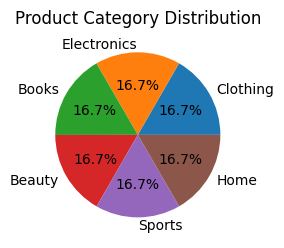

In [ ]:
# Category analysis
plt.subplot(2, 2, 4)
category_counts = transactions_df['product_category'].value_counts()
plt.pie(category_counts.values, labels=category_counts.index, autopct='%1.1f%%')
plt.title('Product Category Distribution')
plt.tight_layout()
plt.show()

# 🎯 SCENARIO 1 CONCLUSIONS


---



In [ ]:
print(f"""
For the Jupyter Notebook Data Scientist scenario with {len(transactions_df):,} transactions:

🐼 PANDAS:
   ✅ Familiar API, rich ecosystem
   ✅ Excellent for visualization and exploration
   ❌ Highest memory usage (~{pandas_result.memory_usage(deep=True).sum() / 1024**2:.0f}MB)
   ❌ Slowest execution ({pandas_time:.2f}s)

⚡ POLARS:
   ✅ {pandas_time/polars_time:.1f}x faster than Pandas
   ✅ Lower memory footprint
   ✅ Expressive API similar to Pandas
   ❌ Smaller ecosystem, some learning curve

🦆 DUCKDB:
   ✅ {pandas_time/duckdb_time:.1f}x faster than Pandas
   ✅ SQL familiarity
   ✅ Excellent for analytical queries
   ✅ Direct parquet file querying
   ❌ Less flexibility for complex transformations

WINNER FOR THIS SCENARIO: DuckDB for SQL-comfortable teams, Polars for performance-focused Python teams
""")


For the Jupyter Notebook Data Scientist scenario with 10,000,000 transactions:

🐼 PANDAS:
   ✅ Familiar API, rich ecosystem
   ✅ Excellent for visualization and exploration
   ❌ Highest memory usage (~8MB)
   ❌ Slowest execution (4.51s)
   
⚡ POLARS:
   ✅ 1.2x faster than Pandas
   ✅ Lower memory footprint
   ✅ Expressive API similar to Pandas
   ❌ Smaller ecosystem, some learning curve
   
🦆 DUCKDB:
   ✅ 1.4x faster than Pandas
   ✅ SQL familiarity
   ✅ Excellent for analytical queries
   ✅ Direct parquet file querying
   ❌ Less flexibility for complex transformations

WINNER FOR THIS SCENARIO: DuckDB for SQL-comfortable teams, Polars for performance-focused Python teams

